In [31]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import utils
import numpy as np
from tensorflow.keras.optimizers import Adam, Adadelta, RMSprop
from tensorflow.keras.models import Sequential, Model
from keras.models import load_model
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, SpatialDropout1D, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM, MaxPooling1D, GlobalMaxPooling1D, Activation
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from google.colab import files


%matplotlib inline

In [32]:
base_data = pd.read_csv('drive/MyDrive/Нейросети/traffic.csv', sep=',')

In [33]:
base_data.head(20)

,Период,Прямые заходы,Переходы из поисковых систем,Переходы из социальных сетей,Переходы по ссылкам на сайтах
0,2022-06-28,0,3,0,0
1,2022-06-29,0,0,0,0
2,2022-06-30,0,0,0,0
3,2022-07-01,0,0,0,0
4,2022-07-02,0,0,0,0
5,2022-07-03,0,0,0,0
6,2022-07-04,0,0,0,0
7,2022-07-05,0,1,0,0
8,2022-07-06,13,2,0,0
9,2022-07-07,14,6,0,0


In [34]:
base_data16 = pd.read_csv('drive/MyDrive/Нейросети/traffic.csv', sep=',')
base_data18 = pd.read_csv('drive/MyDrive/Нейросети/traffic_year.csv', sep=',')
data16_17 = base_data16.iloc[:,1:]
data18_19 = base_data18.iloc[:,1:]

In [ ]:
data = data16_17.copy()
data_ = pd.concat([data16_17,data18_19])
data = np.array(data_)
data_

,Прямые заходы,Переходы из поисковых систем,Переходы из социальных сетей,Переходы по ссылкам на сайтах
0,0,3,0,0
1,0,0,0,0
2,0,0,0,0
3,0,0,0,0
4,0,0,0,0
...,...,...,...,...
83,3,14,1,0
84,1,3,0,0
85,5,5,1,0
86,2,20,1,0


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


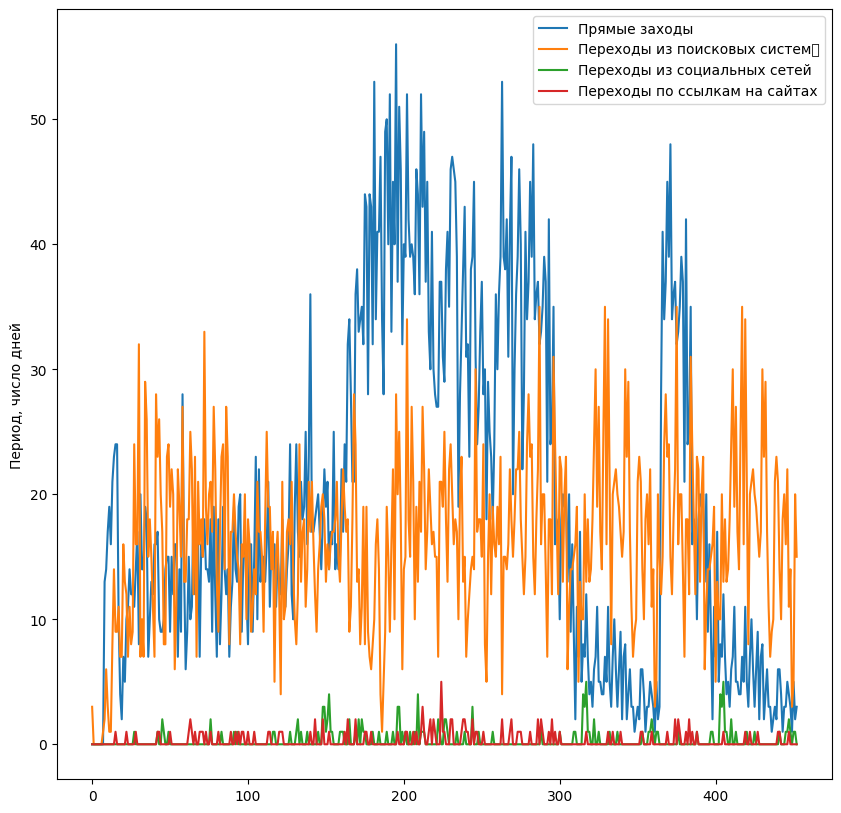

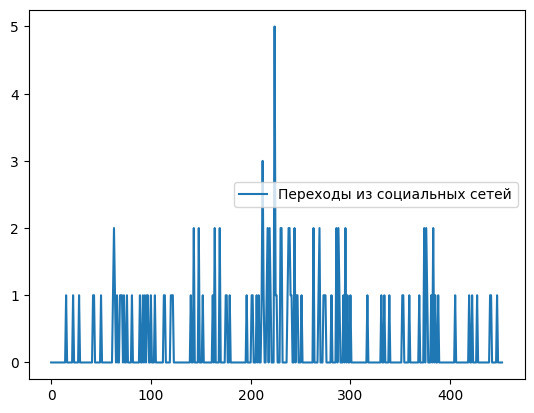

In [ ]:
start = 0
step = data.shape[0]

chanelNames = ['Прямые заходы', 'Переходы из поисковых систем	', 'Переходы из социальных сетей', 'Переходы по ссылкам на сайтах']


plt.figure(figsize=(10,10))
for i in range(4):

  plt.plot(data[start:start+step,i],
           label=chanelNames[i])
plt.ylabel('Период, число дней')
plt.legend()
plt.show()


plt.plot(data[start:start+step,3],
          label='Переходы из социальных сетей')
plt.legend()
plt.show()

In [ ]:
xLen = 60
valLen = 136

trainLen = data.shape[0]-valLen

xTrain,xTest = data[:trainLen], data[trainLen+xLen+2:]


xScaler = MinMaxScaler()
xScaler.fit(xTrain)
xTrain = xScaler.transform(xTrain)
xTest = xScaler.transform(xTest)

yTrain,yTest = np.reshape(data[:trainLen,3],(-1,1)), np.reshape(data[trainLen+xLen+2:,3],(-1,1))
yScaler = MinMaxScaler()
yScaler.fit(yTrain)
yTrain = yScaler.transform(yTrain)
yTest = yScaler.transform(yTest)


trainDataGen = TimeseriesGenerator(xTrain, yTrain,
                               length=xLen, sampling_rate=1,
                               batch_size=20)


testDataGen = TimeseriesGenerator(xTest, yTest,
                               length=xLen, sampling_rate=1,
                               batch_size=20)

In [ ]:
print(trainDataGen[0][0].shape,
      trainDataGen[0][1].shape)

(20, 60, 4) (20, 1)


In [ ]:
def getPred(currModel, xVal, yVal, yScaler):

  predVal = yScaler.inverse_transform(currModel.predict(xVal))
  yValUnscaled = yScaler.inverse_transform(yVal)

  return (predVal, yValUnscaled)


def showPredict(start, step, channel, predVal, yValUnscaled):
  plt.plot(predVal[start:start+step, 0],
           label='Прогноз')
  plt.plot(yValUnscaled[start:start+step, channel],
           label='Базовый ряд')
  plt.xlabel('Время')
  plt.ylabel('Переходы из социальных сетей')
  plt.legend()
  plt.show()

def correlate(a, b):
  ma = a.mean()
  mb = b.mean()
  mab = (a*b).mean()
  sa = a.std()
  sb = b.std()

  val = 1
  if ((sa>0) & (sb>0)):
    val = (mab-ma*mb)/(sa*sb)
  return val


def showCorr(channels, corrSteps, predVal, yValUnscaled):
  for ch in channels:
    corr = []
    yLen = yValUnscaled.shape[0]

    for i in range(corrSteps):
      corr.append(correlate(yValUnscaled[:yLen-i,ch], predVal[i:, 0]))

    own_corr = []

    for i in range(corrSteps):
      own_corr.append(correlate(yValUnscaled[:yLen-i,ch], yValUnscaled[i:, ch]))


    plt.plot(corr, label='Предсказание на ' + str(ch+1) + ' шаг')
    plt.plot(own_corr, label='Эталон')

  plt.xlabel('Время')
  plt.ylabel('Значение')
  plt.legend()
  plt.show()

In [ ]:
DataGen = TimeseriesGenerator(xTest, yTest,
                               length=xLen, sampling_rate=1,
                               batch_size=len(xTest))
xVal = []
yVal = []
for i in DataGen:
  xVal.append(i[0])
  yVal.append(i[1])

xVal = np.array(xVal)
yVal = np.array(yVal)

In [ ]:
yVal[0].shape

(14, 1)

Epoch 1/20
13/13 [==============================] - 3s 112ms/step - loss: 0.7234 - val_loss: 0.1546
Epoch 2/20
13/13 [==============================] - 1s 75ms/step - loss: 0.4466 - val_loss: 0.5811
Epoch 3/20
13/13 [==============================] - 1s 80ms/step - loss: 0.1363 - val_loss: 0.1036
Epoch 4/20
13/13 [==============================] - 1s 74ms/step - loss: 0.1278 - val_loss: 0.0195
Epoch 5/20
13/13 [==============================] - 1s 74ms/step - loss: 0.0511 - val_loss: 0.0101
Epoch 6/20
13/13 [==============================] - 1s 77ms/step - loss: 0.0144 - val_loss: 0.0105
Epoch 7/20
13/13 [==============================] - 1s 75ms/step - loss: 0.0294 - val_loss: 0.0159
Epoch 8/20
13/13 [==============================] - 1s 74ms/step - loss: 0.0144 - val_loss: 0.0150
Epoch 9/20
13/13 [==============================] - 1s 76ms/step - loss: 0.0130 - val_loss: 0.0117
Epoch 10/20
13/13 [==============================] - 1s 104ms/step - loss: 0.0168 - val_loss: 0.0160
Epoch 1

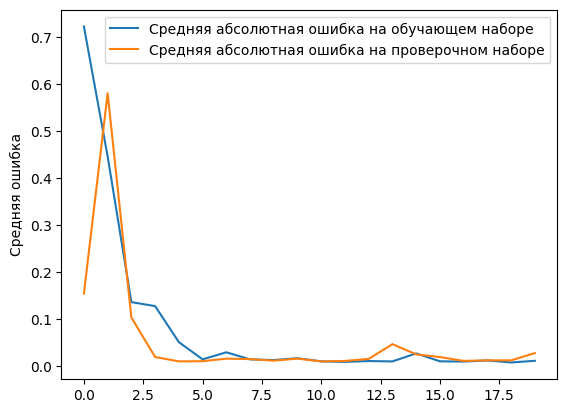

In [35]:
modelC = Sequential()

modelC.add(Conv1D(300, 4, input_shape = (xLen,4), activation="linear"))
modelC.add(Flatten())

modelC.add(Dense(300, activation="linear"))
modelC.add(Dense(1, activation="linear"))

modelC.compile(loss="mse", optimizer=Adam(learning_rate=1e-4))

history = modelC.fit(trainDataGen,
                    epochs=20,
                    verbose=1,
                    validation_data=testDataGen)

plt.plot(history.history['loss'],
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'],
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [36]:
currModel = modelC
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], yScaler)



1/1 [==============================] - 0s 73ms/step


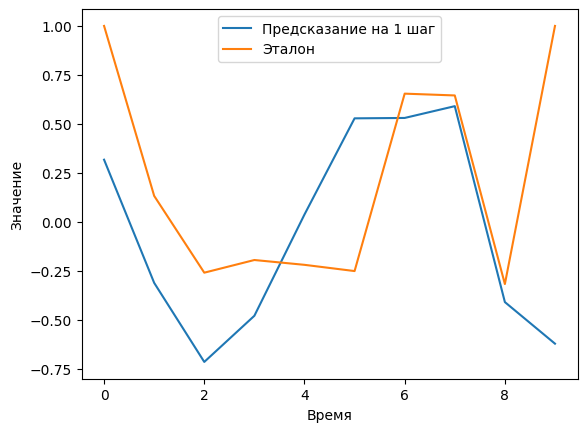

In [37]:
showCorr([0], 10, predVal, yValUnscaled)